In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
dat = pd.read_csv('data/Absenteeism_at_work.csv', sep=';')

In [3]:
dat.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,...,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,...,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,...,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,2


In [4]:
dat.columns = dat.columns.str.lower()
dat.columns

Index(['id', 'reason for absence', 'month of absence', 'day of the week',
       'seasons', 'transportation expense', 'distance from residence to work',
       'service time', 'age', 'work load average/day ', 'hit target',
       'disciplinary failure', 'education', 'son', 'social drinker',
       'social smoker', 'pet', 'weight', 'height', 'body mass index',
       'absenteeism time in hours'],
      dtype='object')

In [5]:
dat.rename(columns={
    'reason for absence': 'reason',
    'month of absence': 'month',
    'day of the week': 'day',
    'transportation expense' : 'transport_expense',
    'distance from residence to work': 'distance',
    'service time': 'service_time',
    'work load average/day ': 'daily_avg_work_load',
    'hit target': 'hit_target',
    'disciplinary failure': 'disciplinary_failure',
    'social drinker': 'social_drinker',
    'social smoker': 'social_smoker',
    'body mass index': 'bmi',
    'absenteeism time in hours': 'absenteeism_hours'
}, inplace=True)

In [6]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    740 non-null    int64  
 1   reason                740 non-null    int64  
 2   month                 740 non-null    int64  
 3   day                   740 non-null    int64  
 4   seasons               740 non-null    int64  
 5   transport_expense     740 non-null    int64  
 6   distance              740 non-null    int64  
 7   service_time          740 non-null    int64  
 8   age                   740 non-null    int64  
 9   daily_avg_work_load   740 non-null    float64
 10  hit_target            740 non-null    int64  
 11  disciplinary_failure  740 non-null    int64  
 12  education             740 non-null    int64  
 13  son                   740 non-null    int64  
 14  social_drinker        740 non-null    int64  
 15  social_smoker         7

In [7]:
dat.head()

,id,reason,month,day,seasons,transport_expense,distance,service_time,age,daily_avg_work_load,...,disciplinary_failure,education,son,social_drinker,social_smoker,pet,weight,height,bmi,absenteeism_hours
0,11,26,7,3,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,...,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,...,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,...,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,2


In [ ]:
dat['Month of absence'].value_counts().sort_index()

Month of absence
0      3
1     50
2     72
3     87
4     53
5     64
6     54
7     67
8     54
9     53
10    71
11    63
12    49
Name: count, dtype: int64

In [ ]:
Q1 = dat['Absenteeism time in hours'].quantile(0.25)
Q3 = dat['Absenteeism time in hours'].quantile(0.75)
IQR = Q3 - Q1

# Keep data within 1.5*IQR
filtered = dat[(dat['Absenteeism time in hours'] >= Q1 - 1.5 * IQR) &
               (dat['Absenteeism time in hours'] <= Q3 + 1.5 * IQR)]

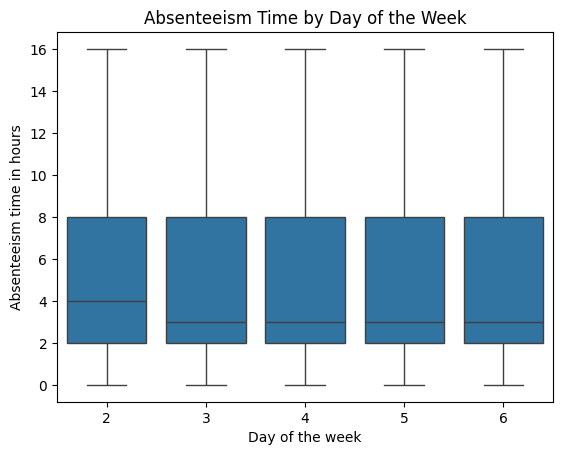

In [ ]:
sns.boxplot(x='Day of the week', y='Absenteeism time in hours', data=filtered)
plt.title('Absenteeism Time by Day of the Week')
plt.show()

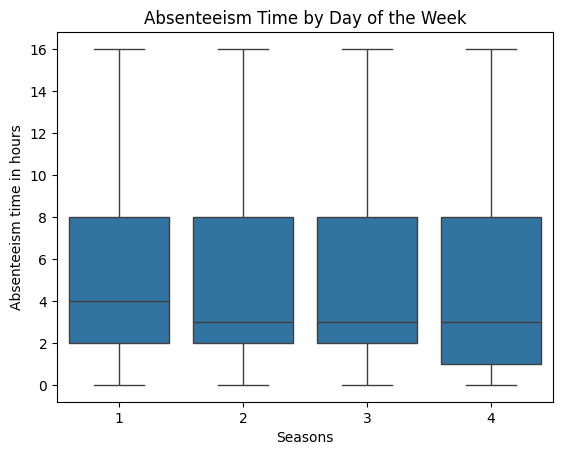

In [ ]:
sns.boxplot(x='Seasons', y='Absenteeism time in hours', data=filtered)
plt.title('Absenteeism Time by Day of the Week')
plt.show()

In [10]:
dat['absenteeism_hours'].var()


np.float64(177.71551036828438)